In [ ]:
import os
import pandas as pd

data_path = "/kaggle/input/cassava-leaf-disease-classification/"
train_csv_data_path  = os.path.join(data_path, "train.csv")
label_json_data_path = os.path.join(data_path, "label_num_to_disease_map.json")
images_dir_data_path = os.path.join(data_path, "train_images")

train_csv = pd.read_csv(train_csv_data_path)
train_csv['label'] = train_csv['label'].astype('string')

label_class = pd.read_json(label_json_data_path, orient='index')
label_class = label_class.values.flatten().tolist()

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import pandas as pd
import numpy as np
import tensorflow as tf


label_encoder = LabelEncoder()
label_encoder.fit(label_class)
func_num_or_list = lambda func, x: func(x) if isinstance(x, (list,np.ndarray,tf.Tensor)) else func([x])[0] 
label_encode = lambda arr_str: func_num_or_list(label_encoder.transform,arr_str)
label_decode = lambda arr: func_num_or_list(label_encoder.inverse_transform,arr)

label_onehotEncoder = OneHotEncoder()
label_onehotEncoder.fit(np.arange(5).reshape(-1,1))
def onehot_decode(arr):
  np_arr = arr.numpy() if isinstance(arr, tf.Tensor) else np.array(arr)
  if len(np_arr.shape) is 1: np_arr = np_arr.reshape(1,-1)
  return label_onehotEncoder.inverse_transform(np_arr).squeeze() 
label_name = lambda arr: label_decode(onehot_decode(arr).tolist()).tolist()
num_classes = len(label_class)

pd.DataFrame(label_encoder.classes_, columns=['Label names'])

,Label names
0,Cassava Bacterial Blight (CBB)
1,Cassava Brown Streak Disease (CBSD)
2,Cassava Green Mottle (CGM)
3,Cassava Mosaic Disease (CMD)
4,Healthy


In [ ]:
train_csv

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


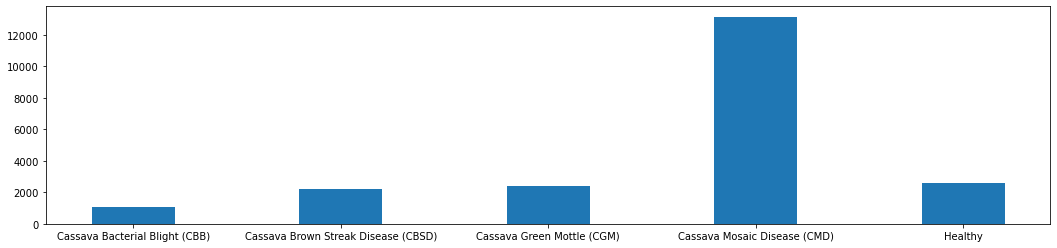

21397


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

tags = label_decode(np.arange(5))
all_labels = np.array(list(map(int, train_csv.iloc[:,1])))

def plot_hist_labels(all_labels):
  fig, ax = plt.subplots()
  all_labels_counts, _, _= plt.hist(all_labels, bins=np.arange(-0.5,5.5), rwidth=0.4)
  plt.xticks(np.arange(5))
  ax.set_xticklabels(tags)
  fig.set_size_inches(18,4)
  plt.show()
  return all_labels_counts

all_labels_counts = plot_hist_labels(all_labels)
num_all_labels = len(all_labels)
print(num_all_labels)

In [ ]:
train_csv

,image_id,label
0,1000015157.jpg,0
1,1000201771.jpg,3
2,100042118.jpg,1
3,1000723321.jpg,1
4,1000812911.jpg,3
...,...,...
21392,999068805.jpg,3
21393,999329392.jpg,3
21394,999474432.jpg,1
21395,999616605.jpg,4


In [ ]:
from functools import partial
import tensorflow as tf
import os, pathlib, shutil
from tqdm.auto import tqdm

AUTOTUNE = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 32
IMAGE_SIZE = [512, 512]
DEFAULT_FUNC = lambda n:n
TRAIN_TFRECORDS_PATH = os.path.join(data_path, 'train_tfrecords')

def decode_image(image, image_size):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32)
    image = tf.reshape(image, image_size)
    return image

def read_tfrecord(example, labeled=True, image_size=[*IMAGE_SIZE, 3], label_transform=DEFAULT_FUNC, image_transform=DEFAULT_FUNC, load_filename=False):
    tfrecord_format = (
        {
            "image_name": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
            "target": tf.io.FixedLenFeature([], tf.int64),
        }
        if labeled
        else
        {
            "image_name": tf.io.FixedLenFeature([], tf.string),
            "image": tf.io.FixedLenFeature([], tf.string),
        }
    )
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = image_transform(decode_image(example["image"], image_size))
    ret = (image,)
    if load_filename:
        filename = example['image_name']
        ret +=(filename,)
    if labeled:
        label = label_transform(tf.cast(example["target"], tf.int32))
        ret +=(label,)
    return ret

def load_dataset(filenames, labeled, image_size, label_transform=DEFAULT_FUNC, image_transform=DEFAULT_FUNC, disable_order=True, load_filename=False):
    ignore_order = tf.data.Options()
    if disable_order: ignore_order.experimental_deterministic = False  # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames)  # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order)  # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(
        partial(read_tfrecord, labeled=labeled, image_size=image_size, label_transform=label_transform, image_transform=image_transform, load_filename=load_filename), 
        num_parallel_calls=AUTOTUNE
    )
    # returns a dataset of (image, label) pairs if labeled=True or just images if labeled=False
    return dataset

def get_dataset(filenames, labeled=True, batch_size=BATCH_SIZE, image_size=[*IMAGE_SIZE, 3], label_transform=DEFAULT_FUNC, image_transform=DEFAULT_FUNC, reshuffle_each_iteration=None, disable_order=True, load_filename=False):
    dataset = load_dataset(filenames, labeled=labeled, image_size=image_size, label_transform=label_transform, image_transform=image_transform, disable_order=disable_order, load_filename=load_filename)
    if reshuffle_each_iteration: dataset = dataset.shuffle(2048, reshuffle_each_iteration=True)
    dataset = dataset.prefetch(buffer_size=AUTOTUNE)
    dataset = dataset.batch(batch_size)
    return dataset

def extract_dataset(filenames, save_dir='.', batch_size=BATCH_SIZE, labeled=True, image_size=[*IMAGE_SIZE,3], flush_path=True, num_samples=None):
    if flush_path: shutil.rmtree(save_dir, ignore_errors=True)
    pathlib.Path(save_dir).mkdir(parents=True, exist_ok=True)

    dataset = get_dataset(filenames, image_size=image_size, labeled=labeled, load_filename=True, disable_order=False, reshuffle_each_iteration=False)
    if num_samples is None:
      print('Computing the number of samples:', end=' ')
      num_samples = tf.reduce_sum([y.shape for _,y,_ in dataset]) if labeled else tf.reduce_sum([y.shape for _,y in dataset])
      print(num_samples.numpy(), 'samples')

    images_path = []
    if labeled: label_list = []
    num_iter = tf.math.ceil(num_samples/32)
    iterator = iter(dataset)
    for _ in tqdm(tf.range(num_iter)):
      item = next(iterator)
      images, image_names = item[:2]
      if labeled:  labels = item[2].numpy()
      for i in tf.range(image_names.shape):
        image_path = os.path.join(save_dir, image_names[i].numpy().decode("utf-8"))
        tf.keras.preprocessing.image.save_img(image_path, images[i])

        if labeled: label_list.append(labels[i])
        images_path.append(image_path)
    del dataset, iterator

    if labeled:
      return np.array(images_path), np.array(label_list)
    else:
      return np.array(images_path)


import matplotlib.pyplot as plt

def show_batch(image_batch, label_batch):
    plt.figure(figsize=(7, 7))
    plt.tight_layout()
    plt.subplots_adjust(right=2., top=2.)
    for n in range(25):
        ax = plt.subplot(5, 5, n + 1)
        plt.imshow(image_batch[n] / 255.0)
        plt.title(label_decode(label_batch[n]), fontsize=10)
        plt.axis("off")
    plt.show()

In [ ]:
from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',np.unique(all_labels),all_labels)
class_weights = np.sum(all_labels_counts)/all_labels_counts/num_classes
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 3.936890524379025,
 1: 1.954956601187757,
 2: 1.7935456831517183,
 3: 0.32523179814561487,
 4: 1.660613116026387}

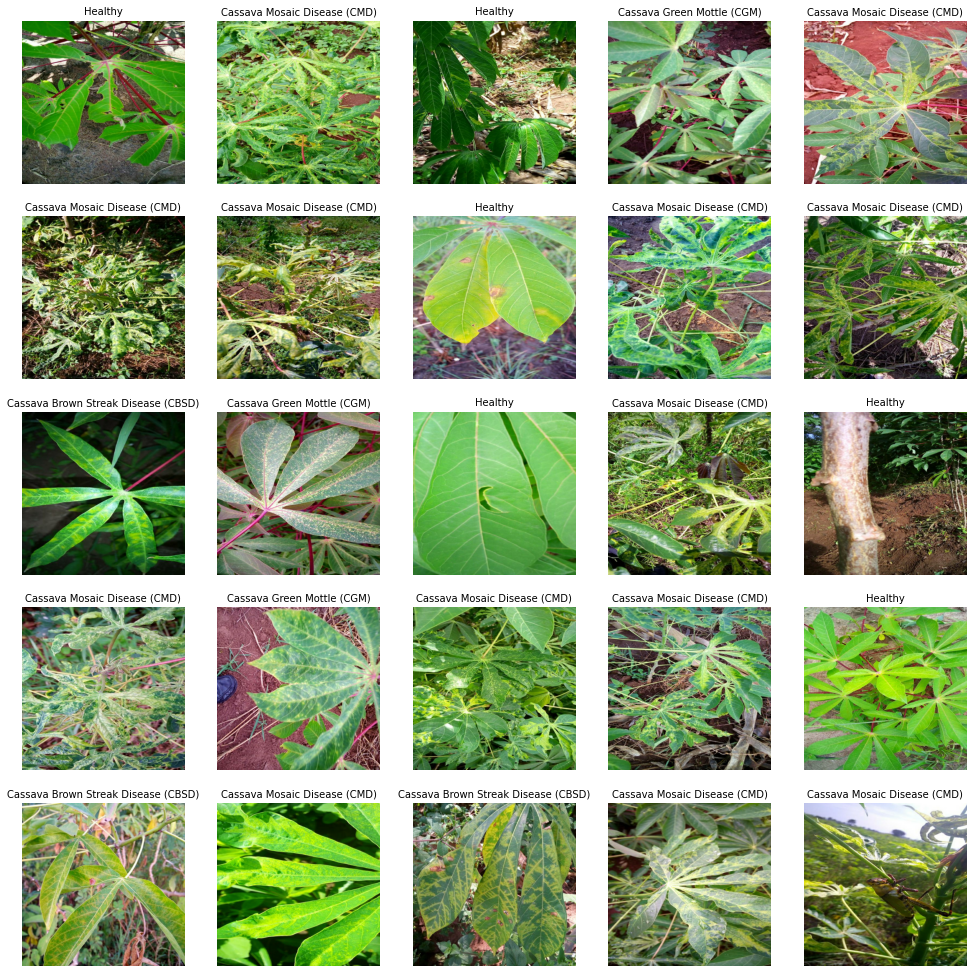

In [ ]:
sample_dataset = get_dataset([os.path.join(data_path,"train_tfrecords","ld_train15-1327.tfrec")])
image_batch, label_batch = next(iter(sample_dataset))
show_batch(image_batch.numpy(), label_batch.numpy())

In [ ]:
def w_noise(img, VARIABILITY=10):
    '''Add random noise to an image'''
    deviation = VARIABILITY*np.random.random()
    noise = np.random.normal(0, deviation, img.shape).astype(np.uint8)
    image = img+noise
    np.clip(image, 0, 255)
    return image

def sp_noise(image, prob):
    '''
    Add salt and pepper noise to image
    prob: Probability of the noise
    '''
    output = np.zeros_like(image)
    thres = 1 - prob 
    for i in range(image.shape[0]):
        for j in range(image.shape[1]):
            rdn = np.random.random()
            if rdn < prob:
                output[i][j] = 0
            elif rdn > thres:
                output[i][j] = 255
            else:
                output[i][j] = image[i][j]
    return output

def add_noise(img):
  max_prob = 0.05
  var = 15
  r = np.random.random()
  if r > 0.5:
    out = sp_noise(img, r*max_prob)
  else:
    out = w_noise(img, r*var)
  return out

In [ ]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator

validation_split = 0.15
batch_size = 128
image_size = [320, 320]

augmentaion_info = dict(rotation_range=360,
                        width_shift_range=0.1,
                        height_shift_range=0.1,
                        brightness_range=[0.1,0.9],
                        shear_range=25,
                        zoom_range=0.3,
                        channel_shift_range=0.1,
                        horizontal_flip=True,
                        vertical_flip=True,
#                         preprocessing_function=add_noise
                        )

train_gen = ImageDataGenerator( rescale=1/255., validation_split=validation_split, **augmentaion_info)
valid_gen = ImageDataGenerator( rescale=1/255., validation_split=validation_split)

train_generator = train_gen.flow_from_dataframe(
                            dataframe=train_csv,
                            directory = images_dir_data_path,
                            x_col = "image_id",
                            y_col = "label",
                            target_size = image_size,
                            class_mode = "categorical",
                            batch_size = BATCH_SIZE,
                            shuffle = True,
                            subset = "training",

)

valid_generator = valid_gen.flow_from_dataframe(
                            dataframe=train_csv,
                            directory = images_dir_data_path,
                            x_col = "image_id",
                            y_col = "label",
                            target_size = image_size,
                            class_mode = "categorical",
                            batch_size = BATCH_SIZE,
                            shuffle = False,
                            subset = "validation"
)
                          

Found 18188 validated image filenames belonging to 5 classes.
Found 3209 validated image filenames belonging to 5 classes.


In [ ]:
import tensorflow as tf

FILENAMES = tf.io.gfile.glob(data_path+"train_tfrecords/ld_train*.tfrec")
split_ind = int(0.9 * len(FILENAMES))
TRAINING_FILENAMES, VALID_FILENAMES = FILENAMES[:split_ind], FILENAMES[split_ind:]

TEST_FILENAMES = tf.io.gfile.glob(data_path + "test_tfrecords/ld_test*.tfrec")
print("Train TFRecord Files:    ", len(TRAINING_FILENAMES))
print("Validation TFRecord Files:", len(VALID_FILENAMES))
print("Test TFRecord Files:      ", len(TEST_FILENAMES))

num_classes = len(label_class)
batch_size = 32
image_size = [320,320]
label_transform = lambda x: tf.one_hot(x, depth=num_classes)
image_rescale = tf.keras.Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(1./255), 
    tf.keras.layers.experimental.preprocessing.Resizing(400, 400)])
def image_rescale(img):
    return tf.image.random_crop(img, size=[*image_size,3])/255.
    
def image_transform(img):
    im = image_rescale(img)
    im = tf.image.random_brightness(im, 0.15)
    im = tf.image.random_flip_left_right(im)
    im = tf.image.random_flip_up_down(im)
    im = tf.image.random_contrast(im, lower=0.8, upper=1.)
    return im


train_dataset = get_dataset(TRAINING_FILENAMES, label_transform=label_transform, image_transform=image_transform, batch_size=batch_size)
valid_dataset = get_dataset(VALID_FILENAMES, label_transform=label_transform, image_transform=image_rescale, batch_size=batch_size, disable_order=False, reshuffle_each_iteration=False)
test_dataset = get_dataset(TEST_FILENAMES, labeled=False, image_transform=image_rescale, batch_size=batch_size, disable_order=False, reshuffle_each_iteration=False)

Train TFRecord Files:     14
Validation TFRecord Files: 2
Test TFRecord Files:       1


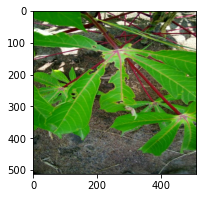

In [ ]:
# Add the image to a batch
image = image_batch[0]

plt.figure(figsize=(3, 3))
plt.imshow(image/255)
# plt.axis("off")
plt.show()

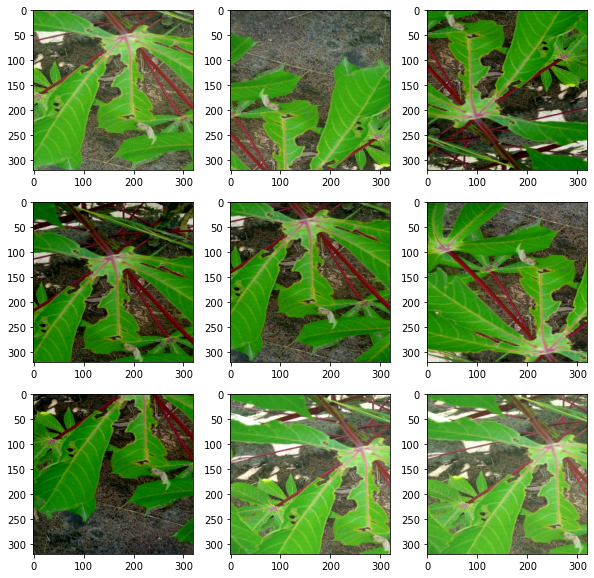

In [ ]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = image_transform(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image)
#   plt.axis("off")
plt.show()

## Classifier

### Train

In [ ]:
import tensorflow as tf


input = tf.keras.layers.Input(shape=(*image_size,3), name='input')
# model_base = tf.keras.applications.DenseNet121(weights='imagenet', input_tensor=input, include_top=False)
model_base = tf.keras.applications.DenseNet121(weights='imagenet', input_tensor=input, include_top=False)

avg_pool = tf.keras.layers.GlobalAveragePooling2D(name='avg_pool')(model_base(input))
hidden_dense1 = tf.keras.layers.Dense(512, activation='relu', name='hidden_dense1',
                                      kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01,l2=0.005),
                                      bias_regularizer  =tf.keras.regularizers.L1L2(l1=0.01,l2=0.005))(avg_pool)
dropout = tf.keras.layers.Dropout(0.2, name='dropout')(hidden_dense1)
hidden_dense2 = tf.keras.layers.Dense(512, activation='relu', name='hidden_dense2',
                                      kernel_regularizer=tf.keras.regularizers.L1(0.001), 
                                      bias_regularizer  =tf.keras.regularizers.L1(0.001))(dropout)
output = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')(hidden_dense2)
model = tf.keras.models.Model(inputs=input, outputs=output, name='Model')


checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model6.h5", save_best_only=True, monitor='val_accuracy', mode='max')

model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.005),
              loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0), 
              metrics=['accuracy', 'categorical_accuracy'])

# tf.keras.utils.plot_model(model, to_file='model6.png', show_shapes=True)

In [ ]:
for layer in model_base.layers[:]: layer.trainable = False
model.summary()

Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 10, 10, 1024)      7037504   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1024)              0         
_________________________________________________________________
hidden_dense1 (Dense)        (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
hidden_dense2 (Dense)        (None, 512)               262656    
_________________________________________________________________
output (Dense)               (None, 5)                 2565  

In [ ]:
# history1 = model.fit(
#       train_generator,
#       steps_per_epoch=train_generator.samples // train_generator.batch_size,
#       epochs=2,
#       validation_data=valid_generator,
#       validation_steps = valid_generator.samples // valid_generator.batch_size,
#       batch_size= train_generator.batch_size,
#       callbacks = [checkpoint_cb]
#       )
history1 = model.fit(
    train_dataset,
    epochs=5,
    validation_data=valid_dataset,
    callbacks=[checkpoint_cb],
)

Epoch 1/5
    519/Unknown - 230s 417ms/step - loss: 100.3295 - accuracy: 0.7152 - categorical_accuracy: 0.7152

In [ ]:
for layer in model_base.layers[:7]: layer.trainable = True
model.summary()

In [ ]:
history2 = model.fit(
    train_dataset,
    epochs=20,
    validation_data=valid_dataset,
    callbacks=[checkpoint_cb],
)
model.save('model6.h5')

In [ ]:
import matplotlib.pyplot as plt

history = {key:(history1.history[key]+history2.history[key]) for key in history1.history.keys()}

plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(history['loss'], marker='o', linestyle='solid', label='Train loss')
plt.plot(history['val_loss'], marker='o', linestyle='dashed', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(122)
plt.plot(history['categorical_accuracy'], marker='o', linestyle='solid', label='Train accuracy')
plt.plot(history['val_categorical_accuracy'], marker='o', linestyle='dashed', label='Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.savefig('model6-history.png')
plt.show()


### TEST

In [ ]:
import tensorflow as tf
best_model = tf.keras.models.load_model("best_model6.h5")

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import pandas as pd

y_true = valid_generator.classes
y_true_vec = tf.one_hot(y_true, num_classes)
y_pred_vec = best_model.predict(valid_generator, valid_generator.batch_size)
y_pred = np.argmax(y_pred_vec, axis=1)

categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()(y_pred=y_pred_vec, y_true=y_true_vec).numpy()
print('Accuracy with "valid_generator": %0.4f'%categorical_accuracy)

loss, accuracy, f1_score = best_model.evaluate(valid_dataset, verbose=0)
print('Accuracy with "valid_dataset": %0.4f'%accuracy)

### Results

In [ ]:
print('Confusion matrix, without normalization')
cm = confusion_matrix(y_true, y_pred)
pd.DataFrame(cm)

In [ ]:
print('Normalized confusion matrix')
cm_p = cm / cm.astype(np.float).sum(axis=1)
pd.DataFrame(cm_p)

In [ ]:
target_names = list(train_generator.class_indices.keys()) # Classes
print(classification_report(y_true, y_pred, target_names=target_names))

In [ ]:
import seaborn as sns

def plot_confusion_matrix(cm, Title='Confusion Matrix'):
    tags = label_decode(np.arange(5))
    plt.figure(figsize=(8,6))
    fmt ='d' if cm.dtype == int else '.2f'
    sns.heatmap(cm,xticklabels=tags, yticklabels=tags, annot=True, fmt=fmt, cmap="Blues", vmin = 0.2);
    plt.title(Title)
    plt.ylabel('True Class')
    plt.xlabel('Predicted Class')
    plt.show()

In [ ]:
cm = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(cm, Title='Confusion matrix, without normalization')

In [ ]:
cm_p = cm / cm.astype(np.float).sum(axis=1)
plot_confusion_matrix(cm_p, Title='Normalized confusion matrix')

In [ ]:
import cv2
test_img_path = data_path+"test_images/2216849948.jpg"

img = cv2.imread(test_img_path)
resized_img = cv2.resize(img, tuple(image_size)).reshape(-1, *image_size, 3)/255.

prediction = best_model.predict(resized_img)
plt.figure(figsize=(8,4))
plt.title(f'[{onehot_decode(prediction)}] {label_name(prediction)}')
plt.imshow(resized_img[0])
plt.show()

In [ ]:
preds = []
ss = pd.read_csv(data_path+'sample_submission.csv')

for image in ss.image_id:
    img = tf.keras.preprocessing.image.load_img(data_path+'test_images/' + image)
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = tf.keras.preprocessing.image.smart_resize(img, tuple(image_size))
    img = tf.reshape(img, (-1, *image_size, 3))
    prediction = best_model.predict(img/255)
    preds.append(np.argmax(prediction))

my_submission = pd.DataFrame({'image_id': ss.image_id, 'label': preds})
my_submission.to_csv('submission.csv', index=False) 
my_submission

## CVAE

## CGAN

In [5]:
# example of training an conditional gan on the fashion mnist dataset
from numpy import expand_dims
from numpy import zeros
from numpy import ones
from numpy.random import randn
from numpy.random import randint
from keras.datasets.fashion_mnist import load_data
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate

# define the standalone discriminator model
def define_discriminator(in_shape=(28,28,1), n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# scale up to image dimensions with linear activation
	n_nodes = in_shape[0] * in_shape[1]
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((in_shape[0], in_shape[1], 1))(li)
	# image input
	in_image = Input(shape=in_shape)
	# concat label as a channel
	merge = Concatenate()([in_image, li])
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(merge)
	fe = LeakyReLU(alpha=0.2)(fe)
	# downsample
	fe = Conv2D(128, (3,3), strides=(2,2), padding='same')(fe)
	fe = LeakyReLU(alpha=0.2)(fe)
	# flatten feature maps
	fe = Flatten()(fe)
	# dropout
	fe = Dropout(0.4)(fe)
	# output
	out_layer = Dense(1, activation='sigmoid')(fe)
	# define model
	model = Model([in_image, in_label], out_layer)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
	return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=10):
	# label input
	in_label = Input(shape=(1,))
	# embedding for categorical input
	li = Embedding(n_classes, 50)(in_label)
	# linear multiplication
	n_nodes = 7 * 7
	li = Dense(n_nodes)(li)
	# reshape to additional channel
	li = Reshape((7, 7, 1))(li)
	# image generator input
	in_lat = Input(shape=(latent_dim,))
	# foundation for 7x7 image
	n_nodes = 128 * 7 * 7
	gen = Dense(n_nodes)(in_lat)
	gen = LeakyReLU(alpha=0.2)(gen)
	gen = Reshape((7, 7, 128))(gen)
	# merge image gen and label input
	merge = Concatenate()([gen, li])
	# upsample to 14x14
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
	gen = LeakyReLU(alpha=0.2)(gen)
	# upsample to 28x28
	gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
	gen = LeakyReLU(alpha=0.2)(gen)
	# output
	out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
	# define model
	model = Model([in_lat, in_label], out_layer)
	return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
	# make weights in the discriminator not trainable
	d_model.trainable = False
	# get noise and label inputs from generator model
	gen_noise, gen_label = g_model.input
	# get image output from the generator model
	gen_output = g_model.output
	# connect image output and label input from generator as inputs to discriminator
	gan_output = d_model([gen_output, gen_label])
	# define gan model as taking noise and label and outputting a classification
	model = Model([gen_noise, gen_label], gan_output)
	# compile model
	opt = Adam(lr=0.0002, beta_1=0.5)
	model.compile(loss='binary_crossentropy', optimizer=opt)
	return model

# load fashion mnist images
def load_real_samples():
	# load dataset
	(trainX, trainy), (_, _) = load_data()
	# expand to 3d, e.g. add channels
	X = expand_dims(trainX, axis=-1)
	# convert from ints to floats
	X = X.astype('float32')
	# scale from [0,255] to [-1,1]
	X = (X - 127.5) / 127.5
	return [X, trainy]

# # select real samples
def generate_real_samples(dataset, n_samples):
	# split into images and labels
	images, labels = dataset
	# choose random instances
	ix = randint(0, images.shape[0], n_samples)
	# select images and labels
	X, labels = images[ix], labels[ix]
	# generate class labels
	y = ones((n_samples, 1))
	return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
	# generate points in latent space
	z_input, labels_input = generate_latent_points(latent_dim, n_samples)
	# predict outputs
	images = generator.predict([z_input, labels_input])
	# create class labels
	y = zeros((n_samples, 1))
	return [images, labels_input], y

# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=100, n_batch=128):
	bat_per_epo = int(dataset[0].shape[0] / n_batch)
	half_batch = int(n_batch / 2)
	# manually enumerate epochs
	for i in range(n_epochs):
		# enumerate batches over the training set
		for j in range(bat_per_epo):
			# get randomly selected 'real' samples
			[X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
			# update discriminator model weights
			d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
			# generate 'fake' examples
			[X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
			# update discriminator model weights
			d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
			# prepare points in latent space as input for the generator
			[z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
			# create inverted labels for the fake samples
			y_gan = ones((n_batch, 1))
			# update the generator via the discriminator's error
			g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
			# summarize loss on this batch
			print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' %
				(i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
	# save the generator model
	g_model.save('cgan_generator.h5')

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
dataset = load_real_samples()
# train model
train(g_model, d_model, gan_model, dataset, latent_dim)

Streaming output truncated to the last 5000 lines.
>90, 149/468, d1=0.719, d2=0.653 g=0.754
>90, 150/468, d1=0.711, d2=0.660 g=0.775
>90, 151/468, d1=0.697, d2=0.652 g=0.749
>90, 152/468, d1=0.704, d2=0.643 g=0.740
>90, 153/468, d1=0.704, d2=0.695 g=0.743
>90, 154/468, d1=0.723, d2=0.672 g=0.754
>90, 155/468, d1=0.707, d2=0.684 g=0.747
>90, 156/468, d1=0.673, d2=0.691 g=0.742
>90, 157/468, d1=0.672, d2=0.691 g=0.727
>90, 158/468, d1=0.633, d2=0.687 g=0.731
>90, 159/468, d1=0.672, d2=0.684 g=0.738
>90, 160/468, d1=0.663, d2=0.702 g=0.751
>90, 161/468, d1=0.684, d2=0.713 g=0.752
>90, 162/468, d1=0.691, d2=0.683 g=0.762
>90, 163/468, d1=0.705, d2=0.674 g=0.766
>90, 164/468, d1=0.659, d2=0.675 g=0.754
>90, 165/468, d1=0.667, d2=0.660 g=0.775
>90, 166/468, d1=0.677, d2=0.671 g=0.750
>90, 167/468, d1=0.684, d2=0.655 g=0.782
>90, 168/468, d1=0.690, d2=0.684 g=0.756
>90, 169/468, d1=0.669, d2=0.714 g=0.773
>90, 170/468, d1=0.667, d2=0.665 g=0.763
>90, 171/468, d1=0.681, d2=0.691 g=0.772
>90, 1

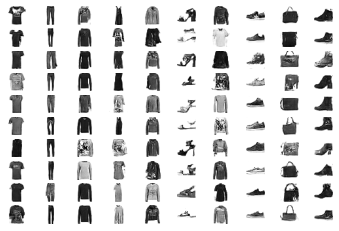

In [6]:
# example of loading the generator model and generating images
from numpy import asarray
from numpy.random import randn
from numpy.random import randint
from keras.models import load_model
from matplotlib import pyplot

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=10):
	# generate points in the latent space
	x_input = randn(latent_dim * n_samples)
	# reshape into a batch of inputs for the network
	z_input = x_input.reshape(n_samples, latent_dim)
	# generate labels
	labels = randint(0, n_classes, n_samples)
	return [z_input, labels]

# create and save a plot of generated images
def save_plot(examples, n):
	# plot images
	for i in range(n * n):
		# define subplot
		pyplot.subplot(n, n, 1 + i)
		# turn off axis
		pyplot.axis('off')
		# plot raw pixel data
		pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
	pyplot.show()

# load model
model = load_model('cgan_generator.h5')
# generate images
latent_points, labels = generate_latent_points(100, 100)
# specify labels
labels = asarray([x for _ in range(10) for x in range(10)])
# generate images
X  = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
save_plot(X, 10)

In [11]:
from numpy import array
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding
# define documents
docs = ['Well done!',
        'Good work',
        'Great effort',
        'nice work',
        'Excellent!',
        'Weak',
        'Poor effort!',
        'not good',
        'poor work',
        'Could have done better.']
# define class labels
labels = array([1,1,1,1,1,0,0,0,0,0])
# integer encode the documents
vocab_size = 50
encoded_docs = [one_hot(d, vocab_size) for d in docs]
print(encoded_docs)
# pad documents to a max length of 4 words
max_length = 4
padded_docs = pad_sequences(encoded_docs, maxlen=max_length, padding='post')
print(padded_docs)
# define the model
model = Sequential()
model.add(Embedding(vocab_size, 8, input_length=max_length))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))
# compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# summarize the model
print(model.summary())
# fit the model
model.fit(padded_docs, labels, epochs=50, verbose=0)
# evaluate the model
loss, accuracy = model.evaluate(padded_docs, labels, verbose=0)
print('Accuracy: %f' % (accuracy*100))

[[17, 48], [35, 48], [23, 43], [14, 48], [27], [10], [29, 43], [13, 35], [29, 48], [47, 35, 48, 49]]
[[17 48  0  0]
 [35 48  0  0]
 [23 43  0  0]
 [14 48  0  0]
 [27  0  0  0]
 [10  0  0  0]
 [29 43  0  0]
 [13 35  0  0]
 [29 48  0  0]
 [47 35 48 49]]
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 4, 8)              400       
_________________________________________________________________
flatten_2 (Flatten)          (None, 32)                0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 33        
Total params: 433
Trainable params: 433
Non-trainable params: 0
_________________________________________________________________
None
Accuracy: 89.999998


In [3]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Embedding, Reshape, Concatenate, LeakyReLU, Flatten, Dropout, Conv2D, Conv2DTranspose
def define_generator(latent_dim, n_classes=5):
    # label input
    in_label = Input(shape=(1,))
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 7 * 7
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((7, 7, 1))(li)
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 7 * 7
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((7, 7, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(1, (7,7), activation='tanh', padding='same')(gen)
    # define model
    model = tf.keras.models.Model([in_lat, in_label], out_layer)
    return model


Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 100)]        0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
dense_3 (Dense)                 (None, 6272)         633472      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 50)        250         input_3[0][0]                    
______________________________________________________________________________________________

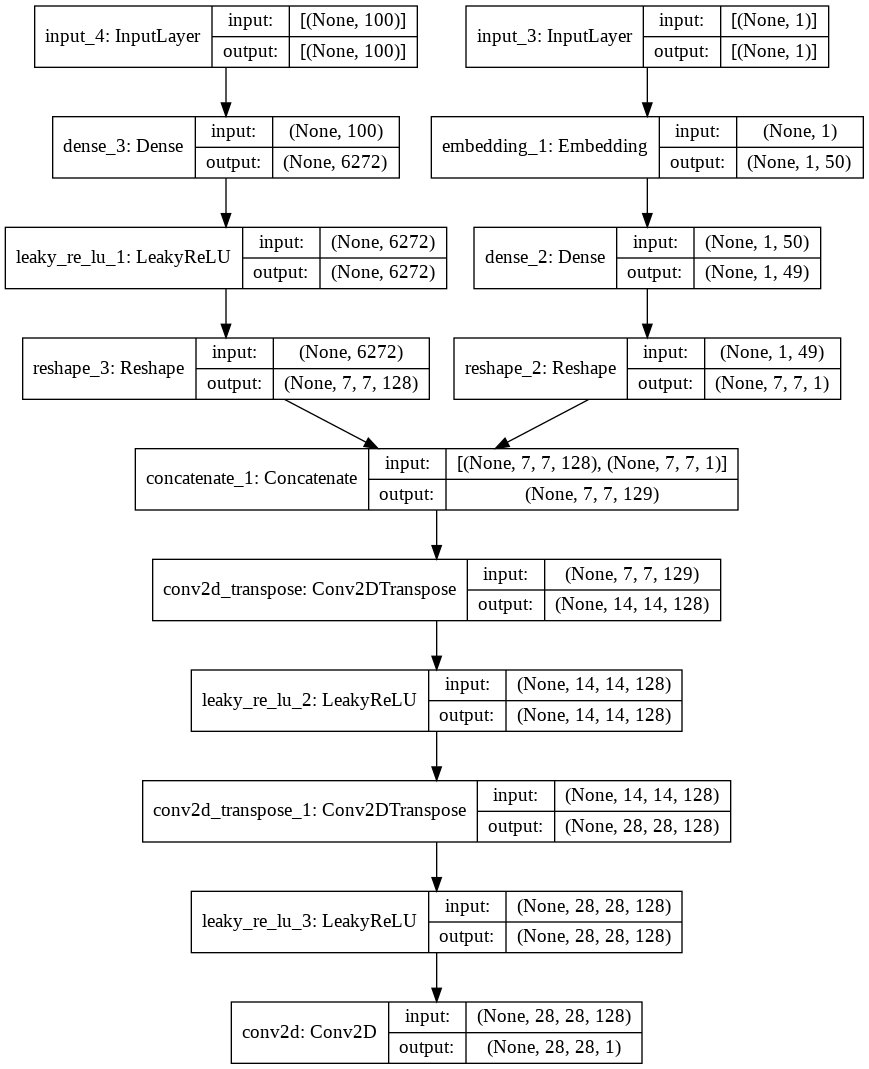

In [4]:
model = define_generator(latent_dim=100, n_classes=5)
model.summary()
tf.keras.utils.plot_model(model, 'model.png', True)

In [8]:
tf.keras.applications.DenseNet121().layers[13].name

'conv2_block1_concat'

Model: "Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 320, 320, 3)]     0         
_________________________________________________________________
densenet121 (Functional)     (None, 10, 10, 1024)      7037504   
_________________________________________________________________
avg_pool (GlobalAveragePooli (None, 1024)              0         
_________________________________________________________________
hidden_dense1 (Dense)        (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
hidden_dense2 (Dense)        (None, 512)               262656    
_________________________________________________________________
output (Dense)               (None, 5)                 2565  

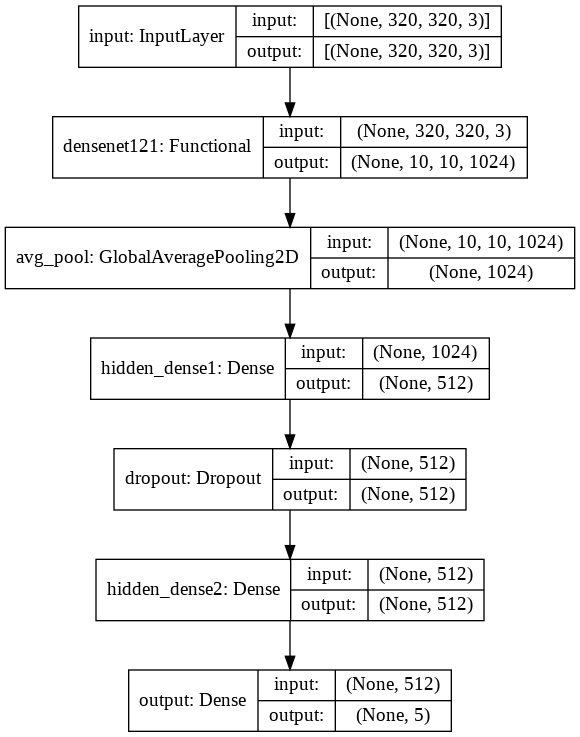

In [3]:
import tensorflow as tf
image_size = [320, 320]; num_classes = 5
input = tf.keras.layers.Input(shape=(*image_size,3), name='input')
# model_base = tf.keras.applications.DenseNet121(weights='imagenet', input_tensor=input, include_top=False)
model_base = tf.keras.applications.DenseNet121(weights='imagenet', input_tensor=input, include_top=False)

avg_pool = tf.keras.layers.GlobalAveragePooling2D( name='avg_pool')(model_base(input))
hidden_dense1 = tf.keras.layers.Dense(512, activation='relu', name='hidden_dense1',
kernel_regularizer=tf.keras.regularizers.L1L2(l1=0.01,l2=0.005),
bias_regularizer  =tf.keras.regularizers.L1L2(l1=0.01,l2=0.005))(avg_pool)
dropout = tf.keras.layers.Dropout(0.2, name='dropout')(hidden_dense1)
hidden_dense2 = tf.keras.layers.Dense(512, activation='relu', name='hidden_dense2',
kernel_regularizer=tf.keras.regularizers.L1(0.001), 
bias_regularizer  =tf.keras.regularizers.L1(0.001))(dropout)
output = tf.keras.layers.Dense(num_classes, activation='softmax', name='output')(hidden_dense2)
model = tf.keras.models.Model(inputs=input, outputs=output, name='Model')

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("best_model.h5", save_best_only=True, monitor='val_accuracy', mode='max')

model.compile(optimizer=tf.keras.optimizers.Adagrad( learning_rate=0.005),
loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.0), 
metrics=['accuracy', 'categorical_accuracy'])

for layer in model_base.layers[:]:  layer.trainable = False
#     for layer in model_base.layers[:13]: layer.trainable = True

model.summary()
tf.keras.utils.plot_model(model, 'model.png', True)